# **Logistic regression with spacy**
*https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/*

**TODO**
- reach a score higher than 0.30 while not just betting it all on trust   

**Preprocessing strategies**
- CountVectorizer: *Convert a collection of text documents to a matrix of token counts.*
- HashingVectorizer: *Convert a collection of text documents to a matrix of token occurrences. (only difference: does not store the resulting vocabulary (i.e. the unique tokens).)*
- TfidfVectorizer: *Convert a collection of raw documents to a matrix of TF-IDF(term frequency–inverse document frequency) features.*
- TfidfTransformer: *Transform a count matrix to a normalized tf or tf-idf representation.*
- SelectKBest: *Select features according to the k highest scores. Selects the best features based on univariate statistical tests*
- StandardScaler: *Standardize features by removing the mean and scaling to unit variance.*

### Imports

In [28]:
# Word tokenization
from spacy.lang.en import English
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import string
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn import metrics
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import spacy
import re
from IPython.display import display
import pandas as pd

from sklearn.naive_bayes import MultinomialNB

In [29]:
def get_most_informative_features(clf, vectorizer, 
                                  label_names, 
                                  max_number_informative_features):
    """
    Prints features with the highest coefficient values, per class
    """
    output = []

    
    try:
        feature_names = vectorizer.get_feature_names()

        label_index = len(label_names)
        
        if label_index == 2:
            label_index = 1
            print('features for binary classification!')
        
        for index in range(label_index):
#             print(str(index) + label_names[index])
            #print('clf.coef_:',len(clf.coef_))
            
            # will work nicely only with 2 categories (code {:>30} is just formatting)
#             output.append(f'\n {label_names[index]}: {label_names[index+1]:>30}:')
            output.append('\n' + label_names[index] + ':\n')
            
            #combine feature names with their coefficients
            coefs_with_fns = sorted(zip(clf.coef_[index], feature_names))
            
            #print(coefs_with_fns)
            
            #half for one label, half for the other
            threshold = int(max_number_informative_features / 2)

            top = zip(coefs_with_fns[:threshold],
                      coefs_with_fns[:-(threshold + 1):-1])
            
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                feat = "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
                output.append(feat)
            
            #print('\n'.join(output))
                
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise 
        return '\n'.join(output)

    return '\n'.join(output)

### Dataset

In [30]:
# read dataset 
#df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Emotions')
df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Patient-journey')

# the features we want to analyze
X = df.loc[:,'discussion_text']

# the labels, or answers, we want to test against
ylabels = df.loc[:,'Label']

# removes all duplicates from list 
Labels = list(dict.fromkeys(ylabels)) 
print(Labels)

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=42)

['Living with diabetes - Nutrition', 'Undiagnosed', 'Clinical Treatment', 'Relatives of diabetes patients', 'Living with diabetes - Lifestyle; Social and Psychological', 'Living with diabetes - Exercise', 'Alternative Treatment', 'Diagnosis ']


### Insights

### Preprocessing 

In [31]:
# Create our list of punctuation marks
punctuations = string.punctuation
punctuations += "...."

# Create our list of stopwords
stop_words = STOP_WORDS 
#other_stop=('•','...in','...the','...you\'ve','–','—','-','⋆','...','....','..','C.','c','|','...The','...The','...When','...A','C','+','1','2','3','4','5','6','7','8','9','10', '2016',  'speak','also', 'seen','[5].',  'using', 'get',  'instead',  "that's",  '......','may', 'e', '...it', 'puts', '...over', '[✯]','happens', "they're",'hwo',  '...a', 'called',  '50s','c;', '20',  'per', 'however,','it,', 'yet', 'one', 'bs,', 'ms,', 'sr.',  '...taking',  'may', '...of', 'course,', 'get', 'likely', 'no,')

#stop_words.add(other_stop) 

# Add other irrelevant words to stop words 
# subject_irrelevant_words = (
#     'diabetes',
#     'type',
#     '2',
#     'diet',
#     'insulin',
#     'year',
# )
# stop_words |= set(subject_irrelevant_words)


# Lexicon of opinion words
from nltk.corpus import opinion_lexicon
opinion_dictionary = set(opinion_lexicon.positive())
opinion_dictionary |= set(opinion_lexicon.negative())


# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [32]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
 
    # remove numbers 
    text = re.sub(r'\d+', '', text)

    # remove all links
    text = re.sub(
        r"(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))", 
        'link_to_website', 
        text
    )

    # Removing spaces and converting text into lowercase
    return text.strip().lower()

def preprocess_text(text):

    return text

# Only one of the following vectorizers is used at a time 

bow_vector = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1), vocabulary=opinion_dictionary) # accuracy: 0.335626783017284779325

bigram_vector = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(2, 2))

tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # accuracy: 0.15846456692913385

### Logistic regression

Logistic Regression Accuracy: 0.3014018691588785


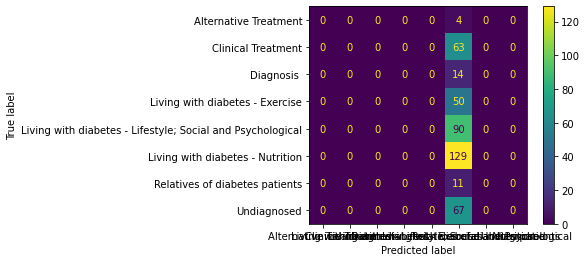


y_test
123                      Living with diabetes - Nutrition
1189                                   Clinical Treatment
462                       Living with diabetes - Exercise
351                      Living with diabetes - Nutrition
1009                     Living with diabetes - Nutrition
                              ...                        
156     Living with diabetes - Lifestyle; Social and P...
567                      Living with diabetes - Nutrition
589                                            Diagnosis 
1035                                          Undiagnosed
549                      Living with diabetes - Nutrition
Name: Label, Length: 428, dtype: object
<class 'pandas.core.series.Series'>

predicted
['Living with diabetes - Nutrition' 'Living with diabetes - Nutrition'
 'Living with diabetes - Nutrition' 'Living with diabetes - Nutrition'
 'Living with diabetes - Nutrition' 'Living with diabetes - Nutrition'
 'Living with diabetes - Nutrition' 'Living with diabe

D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Living with diabetes - Nutrition,0.0,0.0,0.0,4.0
Undiagnosed,0.0,0.0,0.0,63.0
Clinical Treatment,0.0,0.0,0.0,14.0
Relatives of diabetes patients,0.0,0.0,0.0,50.0
Living with diabetes - Lifestyle; Social and Psychological,0.0,0.0,0.0,90.0
Living with diabetes - Exercise,0.3014,1.0,0.4632,129.0
Alternative Treatment,0.0,0.0,0.0,11.0
Diagnosis,0.0,0.0,0.0,67.0
accuracy,0.3014,0.3014,0.3014,0.3014
macro avg,0.0377,0.125,0.0579,428.0


In [33]:
# Emotion datset 
classifier = LogisticRegression( C=0.0005180859503235987, penalty='l2', solver='lbfgs', dual=False, multi_class='multinomial', tol=1e-3, max_iter=1000)
#classifier = LogisticRegression( C=0.5163551401869159, penalty='l2', solver='lbfgs', class_weight='balanced', dual=False, multi_class='multinomial', tol=1e-3, max_iter=10000)

# Patient Journey & tf-idf accuracy: 0.48598130841121495
# classifier = LogisticRegression(
#     penalty="l2",
#     solver="lbfgs",
#     multi_class='multinomial',
#     class_weight='balanced',
#     dual=False,
#     tol=1e-3,
#     random_state=123,
#     C=1.5132766395582273, #1.2692331122575984
#     fit_intercept=False,
#     n_jobs=-1,
# )


clf = MultinomialNB()

# patient jurney 0.5163551401869159
# Create pipeline using Bag of Words
pipe = Pipeline([
  ('cleaner', predictors()),
  ('vectorizer', bow_vector), # bow_vector, bigram_vector, tfidf_vector
  ('classifier', classifier)
])

# model generation
pipe.fit(X_train,y_train)

# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", metrics.accuracy_score(y_test, predicted))
#print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
#print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe, X_test, y_test)  
plt.show()

print("\ny_test")
print(y_test)
print(type(y_test))

print("\npredicted")
print(predicted)
print(type(predicted))

measures_info = metrics.classification_report(y_test, predicted, target_names=Labels, output_dict=True) #, labels=np.unique(predictions) 
info = pd.DataFrame(measures_info).transpose()
info = info.round(decimals=4).astype(object)
display(info)

### Show most informative features

In [34]:
vectorizer = pipe.named_steps['vectorizer']
clf = pipe.named_steps['classifier']
imp_features = get_most_informative_features(clf, vectorizer, Labels, 30)
print('imp_features\n', imp_features)

imp_features
 
Living with diabetes - Nutrition:

	-0.0009	like           		0.0018	patient        
	-0.0006	fat            		0.0017	loss           
	-0.0006	lose           		0.0010	powerful       
	-0.0004	healthy        		0.0010	inhibit        
	-0.0003	good           		0.0010	approve        
	-0.0003	overweight     		0.0009	damage         
	-0.0003	right          		0.0005	problem        
	-0.0003	symptom        		0.0005	unwilling      
	-0.0002	risk           		0.0005	outstanding    
	-0.0002	fast           		0.0005	obstacle       
	-0.0002	great          		0.0005	award          
	-0.0002	thank          		0.0005	achievement    
	-0.0002	obese          		0.0005	stumble        
	-0.0002	cancer         		0.0005	nosey          
	-0.0002	welcome        		0.0005	broken         

Undiagnosed:

	-0.0088	risk           		0.0020	cure           
	-0.0072	fat            		0.0018	wonder         
	-0.0042	like           		0.0016	issue          
	-0.0035	overweight     		0.0013	patient        
	-0.

### Distribution insights

In [35]:
# Organize data in order to display insights into dataset in next block 
X_insight = [spacy_tokenizer(word) for word in X]
data = pd.DataFrame(list(zip(X_insight, ylabels)))
#print(data.head())

In [36]:
from collections import Counter

# join all lists of the same class so that we have 8 lists
# show most common words in each list
word_dict = {}
for label in Labels:
    sentiment = data.loc[data[1] == label]
    sentiment_words = sentiment[0].explode().to_numpy()
    c = Counter(sentiment_words)
    print("\n" + label + "   " + str(len(sentiment)))
    distribution_df = pd.DataFrame.from_dict(c, orient='index').reset_index()
    #print(distribution_df.head())
    #distribution_df[0] = distribution_df[0].map(lambda a: a / len(sentiment))
    #print(distribution_df.sort_values(by=0, ascending=False).head(20))
    print(c.most_common(10))
    word_dict[label] = sentiment_words


Living with diabetes - Nutrition   419
[('diabetes', 616), ('2', 493), ('type', 482), ('diet', 275), ('eat', 202), ('sugar', 181), ('carb', 140), ('low', 136), ('people', 119), ('blood', 115)]

Undiagnosed   187
[('diabetes', 339), ('type', 279), ('2', 258), ('insulin', 77), ('people', 66), ('risk', 64), ('high', 59), ('cause', 49), ('weight', 47), ('fat', 43)]

Clinical Treatment   222
[('diabetes', 273), ('type', 253), ('2', 247), ('insulin', 115), ('metformin', 84), ('year', 73), ('diagnose', 59), ('blood', 59), ('doctor', 56), ('hi', 48)]

Relatives of diabetes patients   51
[('type', 71), ('diabetes', 68), ('2', 60), ('know', 25), ('diabetic', 21), ('family', 19), ('blood', 18), ('sugar', 14), ('year', 14), ('people', 12)]

Living with diabetes - Lifestyle; Social and Psychological   289
[('diabetes', 373), ('2', 308), ('type', 292), ('year', 121), ('hi', 77), ('know', 69), ('diagnose', 67), ('blood', 66), ('like', 62), ('people', 59)]

Living with diabetes - Exercise   185
[('di

### Optimization

**Optimization based on**
- [convergence warning problem info](https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati)
- [scikit documentation hyperparameter optimization](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html)
- [LogisticRegression optimization tutorial](https://coderzcolumn.com/tutorials/machine-learning/scikit-optimize-guide-to-hyperparameters-optimization#3.-Classification-using-Scikit-Learn-)

In [33]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt import space

# function to optimize
def objective(args):
  #penalty=args[0]
  C=args[0]
  fit_intercept = args[1]
  #class_weight = args[2]
  #solver=args[3]

  classifier = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class='multinomial',
    #class_weight='balanced',
    dual=False,
    tol=1e-3,
    random_state=123,
    C=C,
    fit_intercept=fit_intercept,
    n_jobs=-1,
  )


  # Create pipeline using Bag of Words
  pipe = Pipeline([
    ("cleaner", predictors()),
    ('vectorizer', bow_vector),
    ('classifier', classifier)
  ])

  # model generation
  pipe.fit(X_train,y_train)

  # Predicting with a test dataset
  predicted = pipe.predict(X_test)

  return 1 / metrics.accuracy_score(y_test, predicted)


# Define the parameter space to optimize in
search_space = space.Space([
  #space.Categorical(["l2", "none"], name="penalty"),
  space.Real(1e-5, 10000000, prior="log-uniform", transform="identity", name="C"),
  space.Categorical([True, False], name="fit_intercept"),
  #space.Categorical([None, 'balanced'], name="class_weight"),
  #space.Categorical(["newton-cg", "lbfgs", "saga"], name="solver"),
])

# Run optimization
res_gp = gp_minimize(objective, search_space, n_calls=50, random_state=42)


# Display optimization results 
best_params = dict(list(zip(["C", "fit_intercept"], res_gp.x)))
print("Best Parameters : {}".format(best_params))
print("Best Accuracy : {}".format(1 / res_gp.fun))
"Best score=%.4f" % (1 / res_gp.fun)

D:\Program Files\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Program Files\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Program Files\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Program Files\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best Parameters : {'C': 0.0005180859503235987, 'fit_intercept': True}
Best Accuracy : 0.3543307086614173


'Best score=0.3543'

## Multinominal NB

Naive Bayes classifier for multinomial models, Accuracy: 0.4322429906542056


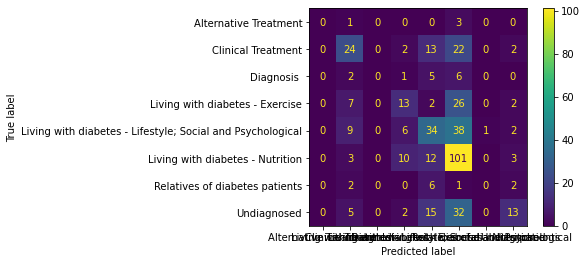

D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Living with diabetes - Nutrition,0.0,0.0,0.0,4.0
Undiagnosed,0.4528,0.381,0.4138,63.0
Clinical Treatment,0.0,0.0,0.0,14.0
Relatives of diabetes patients,0.3824,0.26,0.3095,50.0
Living with diabetes - Lifestyle; Social and Psychological,0.3908,0.3778,0.3842,90.0
Living with diabetes - Exercise,0.441,0.7829,0.5642,129.0
Alternative Treatment,0.0,0.0,0.0,11.0
Diagnosis,0.5417,0.194,0.2857,67.0
accuracy,0.4322,0.4322,0.4322,0.4322
macro avg,0.2761,0.2495,0.2447,428.0


In [37]:
#Naive Bayes
classifier = MultinomialNB()
bow_vector = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1)) # accuracy: 0.335626783017284779325

# Test runs: 
#     DATSET,  VECTORIZER,          ACCURACY,             NOTES

# NB, emotion, bow,                 0.31496062992125984
# NB, emotion, bigram,              0.15551181102362205
# NB, emotion, tfidf,               0.31003937007874016
# NB, emotion, bow no vocab,        0.2440944881889764
# NB, emotion, ngram_range=(1,2),   0.18996062992125984
# NB, emotion, ngram_range=(1,3),   0.17618110236220472

# NB, pat-jur, ngram_range=(1,3),   0.3411214953271028
# NB, pat-jur, tfidf,               0.28738317757009346
# NB, pat-jur, bow no vocab,        0.43457943925233644 - 0.4322429906542056
# NB, pat-jur, bow no vocab,        0.3574766355140187   (NB alpha=1.0e-10)
# NB, pat-jur, bow no vocab,        0.4322429906542056   (add NB stopwords)


# Create pipeline using Bag of Words
pipe2 = Pipeline([
  ('cleaner', predictors()),
  ('vectorizer', bow_vector), # bow_vector, bigram_vector, tfidf_vector
  ('classifier', classifier)
])

# model generation
pipe2.fit(X_train,y_train)

# Predicting with a test dataset
predicted2 = pipe2.predict(X_test)

# Model Accuracy
print("Naive Bayes classifier for multinomial models, Accuracy:", metrics.accuracy_score(y_test, predicted2))
#print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
#print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe2, X_test, y_test)  
plt.show()

measures_info = metrics.classification_report(y_test, predicted2, target_names=Labels, output_dict=True) #, labels=np.unique(predictions) 
info = pd.DataFrame(measures_info).transpose()
info = info.round(decimals=4).astype(object)
display(info)

In [25]:
test_string = "0123456789"
print(test_string[:3]) # take 3 first elements
print(test_string[1:10]) # take elements from second to 10th
print(test_string[3:10]) # take elements from fourth to 10th

012
123456789
3456789
